In [68]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l

d2l.gpu_mem_init()

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [69]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

In [70]:
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [71]:
true_w,features,poly_features,labels = [tf.constant(x, dtype=tf.float32) for x in [true_w, features, poly_features, labels]]
true_w[:2],features[:2],poly_features[:2,:],labels[:2]

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([5. , 1.2], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-1.5197   ],
        [-1.0392958]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.0000000e+00, -1.5197001e+00,  1.1547440e+00, -5.8495486e-01,
          2.2223897e-01, -6.7547314e-02,  1.7108610e-02, -3.7142793e-03,
          7.0557377e-04, -1.1914005e-04,  1.8105715e-05, -2.5013867e-06,
          3.1677979e-07, -3.7031558e-08,  4.0197756e-09, -4.0725687e-10,
          3.8681766e-11, -3.4579225e-12,  2.9194472e-13, -2.3350969e-14],
        [ 1.0000000e+00, -1.0392958e+00,  5.4006785e-01, -1.8709676e-01,
          4.8612218e-02, -1.0104495e-02,  1.7502599e-03, -2.5986254e-04,
          3.3759254e-05, -3.8984281e-06,  4.0516198e-07, -3.8280287e-08,
          3.3153784e-09, -2.6505068e-10,  1.9676146e-11, -1.3632891e-12,
          8.8553791e-14, -5.4137404e-15,  3.1258208e-16, -1.7098171e-17]],
       dtype=float32)>,
 

In [72]:
def evalute_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for x,y in data_iter:
        l = loss(net(x), y)
        metric.add(tf.reduce_sum(l), tf.size(y))
    return metric[0] / metric[1]

In [89]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    batch_size = min(10, train_features.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), train_features.shape[0],batch_size)
    test_iter = d2l.load_array((test_features, test_labels), test_features.shape[0], batch_size, is_train=False)
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    optimizer = tf.keras.optimizers.SGD(0.1)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-6, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, optimizer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add((epoch + 1), (evalute_loss(net, train_iter, loss), (evalute_loss(net, test_iter, loss))))
    print('weight:', net.get_weights()[0].T)

weight: [[ 5.0063295  1.2488744 -3.4145985  5.4669228]]


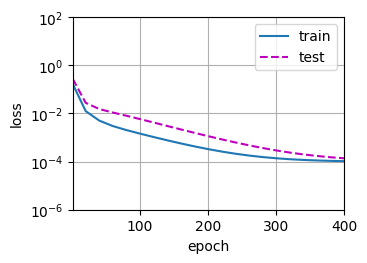

In [90]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.4334574 3.6155455]]


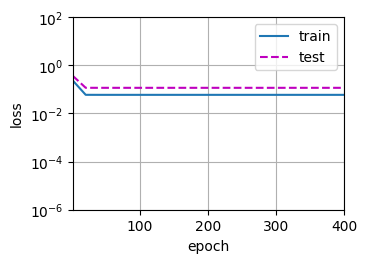

In [91]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.987357    1.2821529  -3.3398175   5.177179   -0.15636817  1.186892
  -0.19514823  0.5271701  -0.16385387 -0.19663598  0.10337865  0.40088752
  -0.02546634 -0.1427816  -0.25874457  0.52888304 -0.01553451 -0.29863226
   0.5199755   0.41283923]]


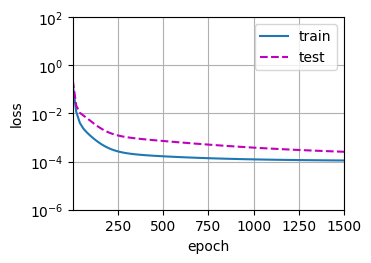

In [92]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)